# PyTorch on MNIST
In this notebook, we showcase the effectiveness of Rational Activations on the MNIST image recognition task. After the neccessary imports, the dataset is transformed and created. The model will be a slightly modified VGG11 architecture to fit the input and output dimensions of the MNIST images.

In [9]:
from rational.utils.examples.pytorch import prepare_data_pytorch, train_pytorch_model, Flatten
from rational.utils.convert_network import convert_pytorch_model_to_rational
from rational.utils.examples.plots import plot_grid

import numpy as np
import torch
from torch.nn import Conv2d, Linear
import torchvision as vision
import matplotlib.pyplot as plt
plt.style.use('bmh')

### Set random seeds to ensure deterministic results in PyTorch and the cuDNN backend

In [2]:
seed = 4242
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Prepare the data generators and training hyperparameters
We apply featurewise normalization, a random rotation range of up to 30 degree and rescaling between 0 and 1 on the inputs. The inputs are reshaped to (32, 32). The outputs are converted into one-hot vectors.

In [3]:
train_loader, test_loader = prepare_data_pytorch(batch_size=256)

### Prepare the model for MNIST
Here we cut off the classification layers used for the ImageNet dataset and add a linear layer predicting the ten output classes needed.

In [4]:
device = 0
epochs = 10

vgg = vision.models.vgg11(pretrained=False).cuda(device)

# change model to fit mnist inputs and outputs   
vgg.features[0] = Conv2d(in_channels=1, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
vgg.avgpool = Flatten()
vgg.classifier = Linear(in_features=512, out_features=10)

### We can now convert the model to make use of the Rational Activations by scanning the model and replacing the ReLU layers appropriately

In [5]:
rational_model = convert_pytorch_model_to_rational(vgg, rational_cuda=True)

### Train the model using the ReLU activation function:

In [6]:
relu_history = train_pytorch_model(vgg, train_loader, test_loader, device=device, epochs=epochs)

[Epoch  10] train_acc: 98.16% - train_loss:  0.057
[Epoch  10] val_acc: 98.23% - val_loss:  0.052
[Epoch  10] Model runtime: 123.590s


### Train the model using the Rational Activations:

In [7]:
rational_history = train_pytorch_model(rational_model, train_loader, test_loader, device=device, epochs=epochs)

[Epoch  10] train_acc: 98.84% - train_loss:  0.038
[Epoch  10] val_acc: 98.91% - val_loss:  0.039
[Epoch  10] Model runtime: 145.961s


### Plot the training and validation metrics:

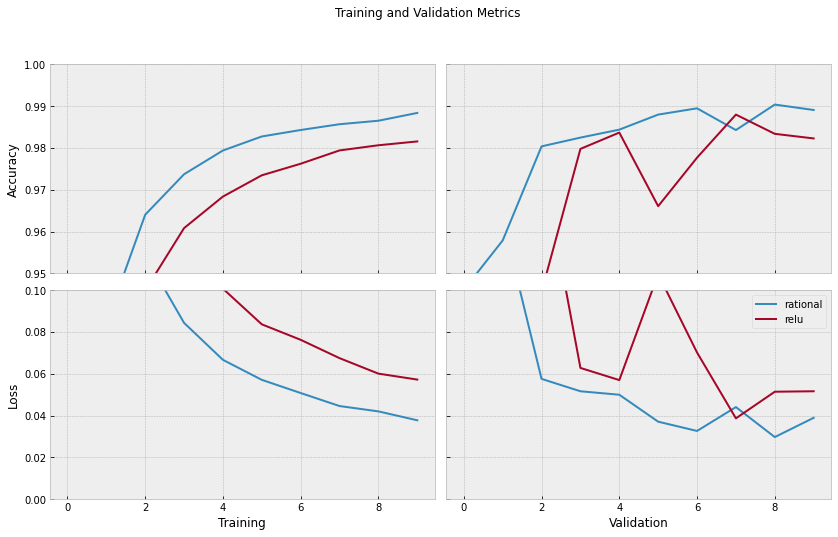

In [10]:
plot_grid({'rational': rational_history, 'relu': relu_history})